#Importing Libraries

In [1]:
# !pip install ipympl
!pip install ipywidgets
%matplotlib widget

#General Import of jax libraries
import jax
import jax.numpy as jnp
from jax import random
from jax import grad
from jax.config import config

#Used the below libraries for Task 1 : Visualisation purposes
from mpl_toolkits import mplot3d
from google.colab import output
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

output.enable_custom_widget_manager()

#Had to use sklearn for task 3 for the dataset and classification report to save time
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#To handle nans especially in Task 3
config.update("jax_debug_nans", False)

#To ignore Warnings
import warnings
warnings.filterwarnings("ignore")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Task 1 
Reference Image : https://en.wikipedia.org/wiki/Multivariate_normal_distribution

In [2]:
@widgets.interact(mean1=(0, 4, 0.1), mean2 = (0, 4, 0.1), sigma1=(0, 4, 0.1), sigma2=(0, 4, 0.1))
def plot_figure(mean1 = 0.6, mean2 = 1.0, sigma1 = 0.5, sigma2 = 0.9):
  mean = jnp.array([mean1, mean2])
  cov = jnp.array([[sigma1, sigma1 * sigma2],
                  [sigma1 * sigma2, sigma2]])
  dist = random.multivariate_normal(key = random.PRNGKey(10), mean = mean, cov = cov, shape = (1000,))
  x = dist[:, 0]
  y = dist[:, 1]
  fig = plt.figure(figsize=(8, 5), dpi = 100)
  axes = fig.add_axes([0.1, 0.1, 0.9, 0.9], projection = '3d')
  axes.scatter(x, y, zs = 0, zdir = 'z', color = "black", s = 2, alpha = 0.4)
  x_h, x_bins = jnp.histogram(x, bins = 15)
  y_h, y_bins = jnp.histogram(y, bins = 15)
  minimum_x = axes.get_ylim()[0]
  for i in x_bins[:-1]:
    minimum_x = min(minimum_x, i)
  maximum_y = axes.get_ylim()[1]
  for i in y_bins[:-1]:
    maximum_y = max(maximum_y, i)
  x_line = x_bins[:-1]
  y_line = y_bins[:-1]
  axes.plot(x_line, x_h / sum(x_h), zdir = 'x', zs = minimum_x, color="red")
  axes.plot(y_line, y_h / sum(y_h), zdir = 'y', zs = maximum_y, color="blue")
  axes.bar3d(jnp.ones(x_bins[:-1].shape[0]) * minimum_x, x_bins[:-1], jnp.zeros(x_bins[:-1].shape[0]), jnp.zeros(x_bins[:-1].shape[0]), 0.3, x_h / sum(x_h), color = "white",shade=False, edgecolor = "black", linewidth = 1)
  axes.bar3d(y_bins[:-1], jnp.ones(y_bins[:-1].shape[0]) * maximum_y, jnp.zeros(y_bins[:-1].shape[0]), jnp.zeros(y_bins[:-1].shape[0]), 0.3, y_h / sum(y_h), color = "white",shade=False, edgecolor = "black", linewidth = 1)
  axes.set_xlabel("X")
  axes.set_ylabel("Y")
  axes.set_zlabel("p(x)")
  axes.zaxis.labelpad = 20
  plt.show()

interactive(children=(FloatSlider(value=0.6, description='mean1', max=4.0), FloatSlider(value=1.0, description…

## Task 2

I have used Box Muller Transformation as well as
cholesky decomposition to solve the problem. This was a completely new topic for me, hence I refered to the following articles and videos for reference, but I took reference of concept and not the code!

Reference Articles/Blogs :  

*   https://www.baeldung.com/cs/uniform-to-normal-distribution

*   https://www.youtube.com/watch?v=HFMrsXNuTSY





In [3]:
def box_muller(sample_size):
  """
    sample_size : int , this argument tells us the number of 
    samples we want as samples from the uniform distribution

  """
  u1 = random.uniform(random.PRNGKey(10), shape = (sample_size, 1))
  u2 = random.uniform(random.PRNGKey(20), shape = (sample_size, 1))
  r = jnp.sqrt(-2 * jnp.log(u1))
  theta = 2 * jnp.pi * u2
  x = r * jnp.cos(theta)
  y = r * jnp.sin(theta)
  return x.reshape(sample_size)

def get_sample_from_multivariate(mean,cov,sample_size, n_dim = 10):
  """
  mean : array of initial means of n_dim shape

  cov : covariance matrix of n_dim x n_dim shape

  sample size : int -> number of samples for each distribution

  n_dim : int -> number of dimensions

  """
  decom = jnp.linalg.cholesky(cov)
  box = box_muller(sample_size * n_dim,)
  # print(box.shape)
  x = box.reshape(n_dim,sample_size)
  # print(x.shape)
  reconstructed_first = jnp.dot(decom, x)
  # print(reconstructed_first.shape)
  # print(reconstructed_covariance.shape,mean.shape)
  reconstructed_mean = reconstructed_first + mean.reshape(n_dim,1)
  reconstructed_covariance = jnp.cov(reconstructed_first)
  return reconstructed_mean,reconstructed_covariance

In [4]:
# Put number of dimensions as 10 according to the task
n_dim=10

mean = random.uniform(random.PRNGKey(30), shape=(n_dim, ))
cov = random.uniform(random.PRNGKey(40), shape = (n_dim, n_dim))
cov_matrix = jnp.dot(cov, cov.T)
r_m ,r_cv = get_sample_from_multivariate(mean,cov_matrix,1000, 10)

In [5]:
print("Initial Mean : ",mean)
print("Sample Mean : ",jnp.mean(r_m,axis=1))

Initial Mean :  [0.72221065 0.8062229  0.89327896 0.51547205 0.1920613  0.77686465
 0.65711343 0.15016603 0.74464905 0.7492653 ]
Sample Mean :  [0.7363439  0.79254    0.9245831  0.5291687  0.19988579 0.7829817
 0.660058   0.15464395 0.7804083  0.7708871 ]


In [6]:
print("Initial Cov : ",cov_matrix)
print("Sample Cov : ",r_cv)

Initial Cov :  [[3.9115505 2.9499266 2.8018746 2.1589684 2.7600415 3.1584394 3.213727
  4.0540943 3.660788  2.5645187]
 [2.9499266 3.7283    2.704622  2.070785  1.8223746 3.4269888 2.971869
  3.6585104 2.990983  2.1660657]
 [2.8018746 2.704622  3.13101   1.7590836 2.0448177 2.519328  2.5059566
  3.5590034 3.060932  2.3109684]
 [2.1589684 2.070785  1.7590836 2.1465812 1.4563955 1.8611819 2.5401561
  2.5666502 2.5506685 1.6676065]
 [2.7600415 1.8223746 2.0448177 1.4563955 2.8707232 2.4213207 2.21118
  2.635757  2.6418123 2.1335623]
 [3.1584394 3.4269888 2.519328  1.8611819 2.4213207 4.045715  2.8199975
  3.4319377 3.325764  2.277597 ]
 [3.213727  2.971869  2.5059566 2.5401561 2.21118   2.8199975 3.6329763
  3.6899784 3.1945548 2.5409222]
 [4.0540943 3.6585104 3.5590034 2.5666502 2.635757  3.4319377 3.6899784
  4.9538865 4.1108856 2.9343994]
 [3.660788  2.990983  3.060932  2.5506685 2.6418123 3.325764  3.1945548
  4.1108856 4.2839313 2.4841545]
 [2.5645187 2.1660657 2.3109684 1.6676065 2.

## Task 3

In [7]:
class NeuralNetwork():
  def __init__(self, input_size, n_hidden, hidden_size, output_size, eta = 1e-4):
    self.input_size = input_size
    self.output_size = output_size
    self.W = []
    self.b = []
    self.act = []
    self.eta = eta
    self.n_hidden = n_hidden
    self.initializer = jax.nn.initializers.xavier_normal()
    for i in range(n_hidden + 1):
      if(i == 0):
        self.W.append(self.initializer(random.PRNGKey(10), (input_size, hidden_size[i]), dtype = jnp.float32))
        self.b.append(random.uniform(key = random.PRNGKey(20), shape = (hidden_size[i], ), dtype = jnp.float32, minval = 1e-7, maxval = 1.0))
      elif(i == n_hidden):
        self.W.append(self.initializer(random.PRNGKey(30), (hidden_size[i - 1], output_size), dtype = jnp.float32))
        self.b.append(random.uniform(key = random.PRNGKey(40), shape = (output_size, ), dtype = jnp.float32, minval = 1e-7, maxval = 1.0))
      else:
        self.W.append(self.initializer(random.PRNGKey(50), (hidden_size[i - 1], hidden_size[i]), dtype = jnp.float32))
        self.b.append(random.uniform(key = random.PRNGKey(60), shape = (hidden_size[i], ), dtype = jnp.float32, minval = 1e-7, maxval = 1.0))
    self.loss_grad = jax.value_and_grad(self.categorical_cross_entropy)

  def categorical_cross_entropy(self, thetha, bias, x, y_true):
    out = x
    for i in range(self.n_hidden + 1):
      out = jnp.dot(out, thetha[i]) + bias[i]
      if(i != self.n_hidden):
        out = jax.nn.tanh(out) 
      else:
        out = jax.nn.softmax(out)
    n = y_true.shape[0]
    return -jnp.sum(y_true * jnp.log(out)) / (n + 1e-7)

  def train(self, x, y, epochs = 10):
    x = jnp.array(x).astype(jnp.float32)
    y = jnp.array(y).astype(jnp.float32)
    history_loss = []
    for epoch in range(1, epochs + 1):
      loss, grad = self.loss_grad(self.W, self.b, x, y)
      out = x
      for i in range(self.n_hidden + 1):
        out = jnp.dot(out, self.W[i]) + self.b[i]
        if(i != self.n_hidden):
          out = jax.nn.leaky_relu(out)
        else:
          out = jax.nn.softmax(out)
      print(f"Epoch {epoch}  ->  Training Loss : {loss}" )
      history_loss.append(loss)
      for i in range(self.n_hidden + 1):
        self.W[i] = self.W[i] - self.eta * grad[i]
    return history_loss
  
  def predict(self, x):
    x = jnp.array(x).astype(jnp.float32)
    out = x
    for i in range(self.n_hidden + 1):
      out = jnp.dot(out, self.W[i]) + self.b[i]
      if(i != self.n_hidden):
        out = jax.nn.tanh(out)
      else:
        out = jax.nn.softmax(out)
    return out

In [8]:
def get_mnist_dataset():
  
  mnist = fetch_openml('mnist_784')
  x = mnist.data
  y = mnist.target
  x = x / 255.
  y = [[0 for _ in range(10)] for _ in range(x.shape[0])]
  for index, i in enumerate(mnist.target):
    i = int(i)
    y[index][i] = 1
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify=y)
  return x_train, x_test, y_train, y_test

In [9]:
def train_mnist(n_h1=256,n_h2=128,lr=3e-2,epochs=100):
  x_train, x_test, y_train, y_test = get_mnist_dataset()
  ntw = NeuralNetwork(input_size = x_train.shape[1], n_hidden = 2, hidden_size = [n_h1, n_h2], output_size = 10, eta = lr)
  history = ntw.train(x_train, y_train, epochs = epochs)
  print("\n\n\nEvaluating on test set")
  y_pred = ntw.predict(x_test)
  cf = classification_report(jnp.argmax(jnp.array(y_test), axis = -1), jnp.argmax(jnp.array(y_pred), axis = -1))
  print(cf)
  return history

In [10]:
history = train_mnist(100)

Epoch 1  ->  Training Loss : 2.3898794651031494
Epoch 2  ->  Training Loss : 2.3348448276519775
Epoch 3  ->  Training Loss : 2.294644832611084
Epoch 4  ->  Training Loss : 2.262286901473999
Epoch 5  ->  Training Loss : 2.2343850135803223
Epoch 6  ->  Training Loss : 2.209156036376953
Epoch 7  ->  Training Loss : 2.185596466064453
Epoch 8  ->  Training Loss : 2.163114309310913
Epoch 9  ->  Training Loss : 2.1413462162017822
Epoch 10  ->  Training Loss : 2.120063304901123
Epoch 11  ->  Training Loss : 2.099118232727051
Epoch 12  ->  Training Loss : 2.0784144401550293
Epoch 13  ->  Training Loss : 2.0578880310058594
Epoch 14  ->  Training Loss : 2.0374953746795654
Epoch 15  ->  Training Loss : 2.017207384109497
Epoch 16  ->  Training Loss : 1.997004747390747
Epoch 17  ->  Training Loss : 1.9768744707107544
Epoch 18  ->  Training Loss : 1.9568089246749878
Epoch 19  ->  Training Loss : 1.9368036985397339
Epoch 20  ->  Training Loss : 1.9168579578399658
Epoch 21  ->  Training Loss : 1.896972

In [11]:
def plot_loss(history):
  fig = plt.figure()
  axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
  axes.plot(range(1, len(history) + 1), history)
  axes.set_xlabel("Epochs")
  axes.set_ylabel("Training Loss")
  plt.show()

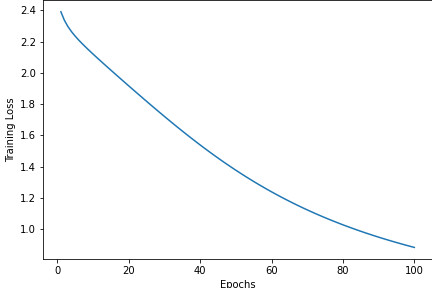

In [12]:
plot_loss(history)